Name: Antony Krymski

Username: agk-123

In [542]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [660]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

plt.style.use("bmh")
plt.rcParams.update({'font.size': 10})

def sharpe_ratio(returns):
    mean_return = tf.reduce_mean(returns)
    std_return = tf.math.reduce_std(returns)
    sharpe = mean_return / std_return
    return sharpe * np.sqrt(252.0)

def scale(a):
    # minmax scaling 
    maxv = np.max(a, axis=0)
    minv = np.min(a, axis=0)
    return (a - minv) / (maxv - minv) * 2. - 1.

def split(X, y, test_size=0.33):
    # timeseries split 
    i = int(np.floor(len(X) * (1 - test_size)))
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i:], y[i:]
    return X_train, X_test, y_train, y_test

def window(data, timesteps, strides=1):
    # windowing data 
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

def download(ticker='^GSPC'):
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=0&period2=9999999999&interval=1d&events=history&includeAdjustedClose=true'
    return pd.read_csv(url, index_col='Date', parse_dates=True)

def plot(x, allocations=False):
    plt.figure(figsize=(16, 8))
    plt.margins(x=0, y=0)
    if allocations: plt.title('Allocations')
    plt.plot(x)
    plt.show()

def plot_forecast(x, y, y_pred):
    t1 = np.arange(0, len(x), 1)
    t2 = np.arange(len(x), len(x) + len(y), 1)
    fig, ax = plt.subplots(figsize=(16, 2))
    ax.margins(x=0, y=0)
    ax.plot(t1, x, color='blue')
    ax.plot(t2, y, color='blue', label='Actual')
    ax.plot(t2, y_pred, color='red', label='Forecast')
    ax.axvline(x=len(x), color='gray', linestyle='--')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

def plot_timeseries(**kwargs):
    fig, (ax) = plt.subplots(1, 1, sharex=True, figsize=(16, 8))
    ax.margins(x=0, y=0)
    index = kwargs['index'] if 'index' in kwargs else None
    for key, value in kwargs.items():
        if key == 'title':
            ax.set_title(value)
        elif key == 'index':
            pass
        else:
            if index is None:
                ax.plot(value, label=key)
            else:
                ax.plot(index, value, label=key)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

def plot_training(history, metric='loss'):
    plot_timeseries(index=range(history.params['epochs']), title=metric, train=history.history[metric], test=history.history['val_' + metric])

In [649]:
WINDOWS = 10
TIMESTEPS = 25
FEATURES = 1
CODE_SIZE = 32
BATCH_SIZE = 512

# Data

# Pre-processing

In [650]:
# works on EURTHB, USDZAR, USDSGD

In [571]:
timeseries = download('JPY=X')['Close']

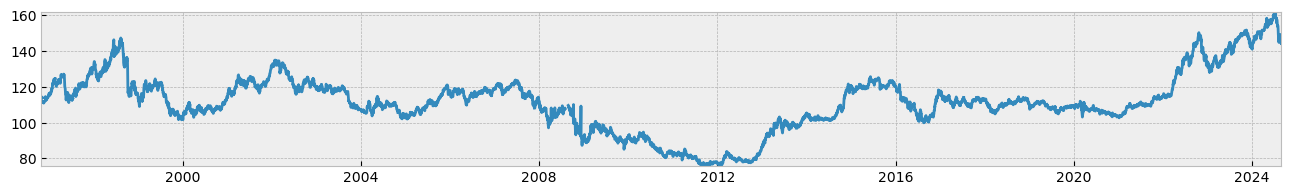

In [547]:
plot(timeseries)

In [548]:
# Transform to log returns
timeseries = np.log(timeseries).diff().dropna()
timeseries

Date
1996-11-04    0.003342
1996-11-05    0.003244
1996-11-06   -0.002629
1996-11-11   -0.005564
1996-11-12    0.001888
                ...   
2024-08-23    0.007442
2024-08-26   -0.015176
2024-08-27    0.003577
2024-08-28   -0.003751
2024-08-28    0.003259
Name: Close, Length: 7189, dtype: float64

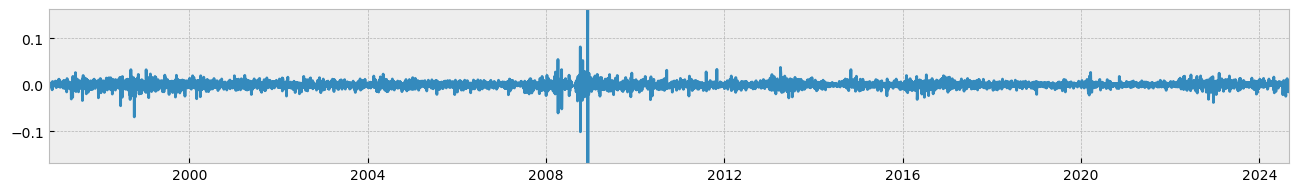

In [549]:
plot(timeseries)

Outliers 0.02190467173742223
(5551, 250) (1388, 250)
(5551,) (1388,)


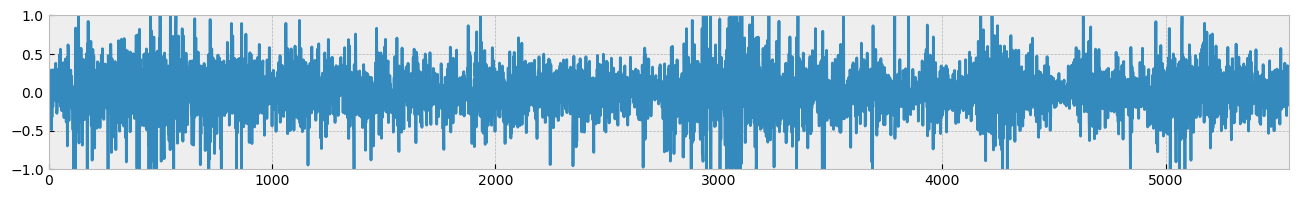

In [550]:
def load_data(w=None):
    X = timeseries.values

    # remove outliers
    outliers = np.quantile(np.abs(X), 0.99)
    X = np.clip(X, -outliers, outliers)
    print('Outliers', outliers)

    # scale
    X = X / outliers

    # generate lags
    X = window(X, w).astype(np.float32)
    y = timeseries[w:]
    return split(X, y, 0.2)

x_train, x_test, y_train, y_test = load_data(WINDOWS * TIMESTEPS)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

assert(np.isfinite(x_train).all() == True)
assert(np.isfinite(y_train).all() == True)

plot(x_train[:, 0])

In [551]:
evals = pd.DataFrame(index=['RMSE', 'MAE'])

def eval(name, y_pred, y_test):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    evals[name] = [ rmse, mae ]

In [552]:
# Base cases
eval('Persistence', y_test.shift(1).fillna(0), y_test)
eval('Zero', np.zeros(len(y_test)), y_test)
eval('Mean', np.full(len(y_test), np.mean(x_train[:, -1])), y_test)
evals

,Persistence,Zero,Mean
RMSE,0.007791,0.005562,0.005567
MAE,0.005549,0.003885,0.003894


In [553]:
# Linear Regression
model = LinearRegression()
model.fit(x_train, y_train)
eval('LR', model.predict(x_test), y_test)

In [554]:
# # ARIMA
# import pmdarima as pm
# model = pm.auto_arima(x_train[:, -1], stationary=True, maxiter=5)
# eval('ARIMA', model.predict(len(x_test)), y_test)

Epoch 1/40
11/11 [==============================] - 5s 263ms/step - loss: 3.6236e-04 - mae: 0.0123 - val_loss: 3.2515e-05 - val_mae: 0.0040
Epoch 2/40
11/11 [==============================] - 2s 159ms/step - loss: 7.7003e-05 - mae: 0.0060 - val_loss: 3.6567e-05 - val_mae: 0.0043
Epoch 3/40
11/11 [==============================] - 2s 159ms/step - loss: 9.7910e-05 - mae: 0.0072 - val_loss: 4.7096e-05 - val_mae: 0.0055
Epoch 4/40
11/11 [==============================] - 2s 159ms/step - loss: 8.4912e-05 - mae: 0.0066 - val_loss: 3.7744e-05 - val_mae: 0.0044
Epoch 5/40
11/11 [==============================] - 2s 159ms/step - loss: 8.4109e-05 - mae: 0.0064 - val_loss: 6.5162e-05 - val_mae: 0.0068
Epoch 6/40
11/11 [==============================] - 2s 161ms/step - loss: 6.6936e-05 - mae: 0.0055 - val_loss: 3.8027e-05 - val_mae: 0.0047
Epoch 7/40
11/11 [==============================] - 2s 158ms/step - loss: 8.3030e-05 - mae: 0.0065 - val_loss: 3.1491e-05 - val_mae: 0.0039
Epoch 8/40
11/11 [==

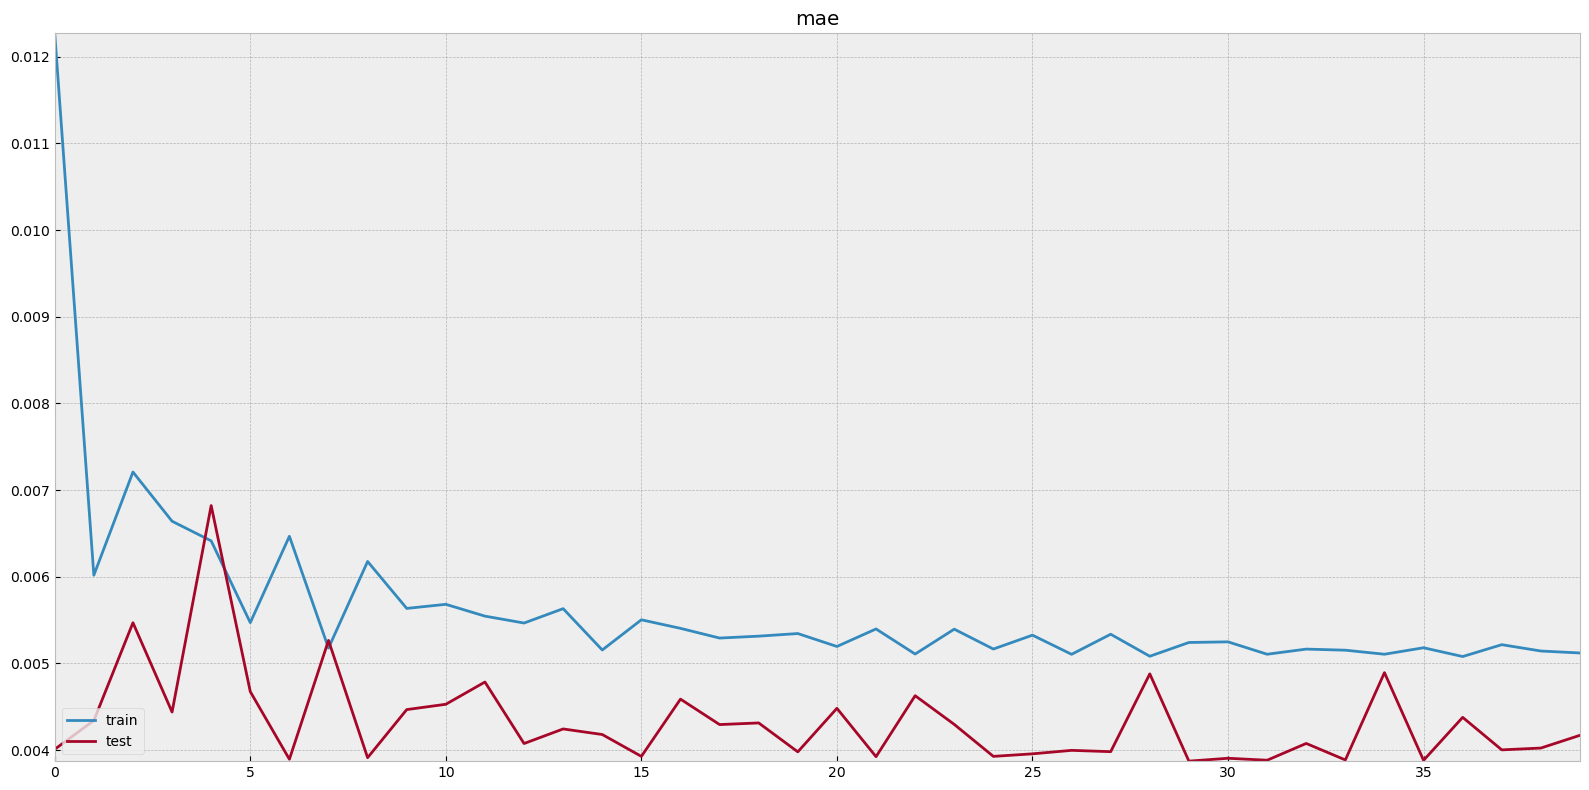

44/44 [==============================] - 1s 13ms/step


In [557]:
def build_lstm(input_shape):
    input = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(input)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="linear")(x)
    return Model(input, x)

model = build_lstm((WINDOWS*TIMESTEPS, FEATURES))
model.compile(loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=40, validation_data=(x_test, y_test))
plot_training(history, 'mae')

eval('LSTM', model.predict(x_test), y_test)

In [559]:
evals

,Persistence,Zero,Mean,LR,LSTM
RMSE,0.007791,0.005562,0.005567,0.005762,0.005775
MAE,0.005549,0.003885,0.003894,0.004053,0.004170


# Data Generation

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, timesteps=TIMESTEPS, n_windows=WINDOWS):
        self.timesteps = timesteps
        self.n_windows = n_windows
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = data
        self.indexes = np.arange(len(self.data) - (timesteps * n_windows) - timesteps)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size
    
    def get_window(self, idx):
        return self.data[idx:idx+self.timesteps, 0]
    
    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]

        for idx in indexes:
            windows = []
            for w in range(self.n_windows):
                window = self.get_window(idx + (w * self.timesteps))
                windows.append(window)

            y_positive = self.get_window(idx + (self.n_windows * self.timesteps))

            y_negative = self.get_window(idx + ((self.n_windows-1) * self.timesteps))
            y_negative = np.random.normal(np.mean(y_negative), np.std(y_negative), len(y_negative))

            # positive sample
            x.append(windows)
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(windows)
            y.append(y_negative)
            labels.append(0)
        
        x = np.array(x).astype(np.float32)
        y = np.array(y).astype(np.float32)
        labels = np.array(labels).astype(np.float32)

        x = np.expand_dims(x, axis=-1)
        y = np.expand_dims(y, axis=-1)
        
        return (x, y), labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

Batches: 10
x shape: (512, 10, 25, 1), y shape: (512, 25, 1), labels shape: (512,)


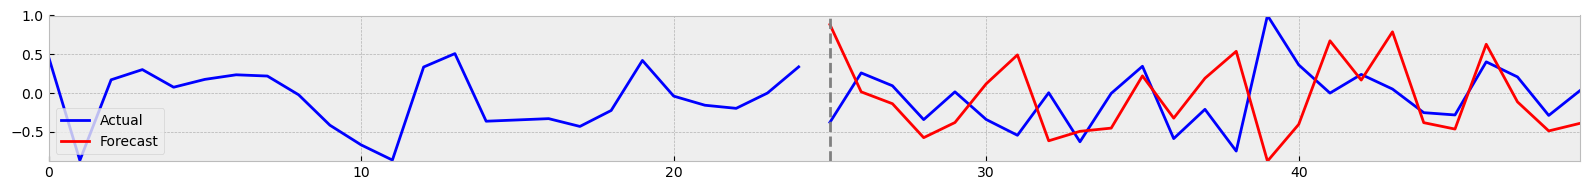

In [14]:
# Test generator
dg = DataGenerator(x_train, batch_size=BATCH_SIZE, shuffle=True)
print('Batches:', len(dg))

# Get the first batch
(bx, by), labels = dg.__getitem__(0)
print(f"x shape: {bx.shape}, y shape: {by.shape}, labels shape: {labels.shape}")

plot_forecast(bx[0, -1, :, 0], by[0, :, 0], by[1, :, 0])

# CPC Model Architecture

In [256]:
def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv1D(16, 7, activation='relu', padding='same')(input)
    x = Conv1D(32, 5, activation='relu', padding='same')(x)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    # x = Conv1D(64, 9, activation='relu', padding='same')(input)
    x = Flatten()(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    return Model(input, x, name='encoder')

encoder = build_encoder((TIMESTEPS, FEATURES), CODE_SIZE)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 25, 1)]           0         
                                                                 
 conv1d_35 (Conv1D)          (None, 25, 16)            128       
                                                                 
 conv1d_36 (Conv1D)          (None, 25, 32)            2592      
                                                                 
 conv1d_37 (Conv1D)          (None, 25, 64)            6208      
                                                                 
 flatten_13 (Flatten)        (None, 1600)              0         
                                                                 
 encoder_embedding (Dense)   (None, 32)                51232     
                                                                 
Total params: 60,160
Trainable params: 60,160
Non-trainable

In [257]:
def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    x = GRU(16, return_sequences=False, name="context")(input)
    # x = Dropout(0.5)(x)
    # x = LSTM(64, return_sequences=True)(x)
    # x = LSTM(32, return_sequences=False)(x)
    x = Dense(code_size, activation="linear", name="preds")(x)
    return Model(input, x, name="context")

context = build_context((WINDOWS, CODE_SIZE), CODE_SIZE)
context.summary()

Model: "context"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 10, 32)]          0         
                                                                 
 context (GRU)               (None, 16)                2400      
                                                                 
 preds (Dense)               (None, 32)                544       
                                                                 
Total params: 2,944
Trainable params: 2,944
Non-trainable params: 0
_________________________________________________________________


In [258]:
x_input = Input((WINDOWS, TIMESTEPS, FEATURES))
x_encoded = TimeDistributed(encoder)(x_input)

y_pred = context(x_encoded)

y_input = Input((TIMESTEPS, FEATURES))
y_encoded = encoder(y_input)

output = K.mean(y_encoded * y_pred, axis=-1)
output = K.sigmoid(output)

model = Model(inputs=[x_input, y_input], outputs=output, name='CPC')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "CPC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 10, 25, 1)]  0           []                               
                                                                                                  
 input_54 (InputLayer)          [(None, 25, 1)]      0           []                               
                                                                                                  
 time_distributed_11 (TimeDistr  (None, 10, 32)      60160       ['input_53[0][0]']               
 ibuted)                                                                                          
                                                                                                  
 encoder (Functional)           (None, 32)           60160       ['input_54[0][0]']             

In [259]:
train_gen = DataGenerator(x_train, batch_size=BATCH_SIZE, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=BATCH_SIZE, shuffle=True)

In [260]:
history = model.fit(train_gen, epochs=200, validation_data=test_gen)

Epoch 1/200
10/10 [==============================] - 3s 91ms/step - loss: 0.6931 - binary_accuracy: 0.4992 - val_loss: 0.6931 - val_binary_accuracy: 0.5010
Epoch 2/200
10/10 [==============================] - 0s 37ms/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6930 - val_binary_accuracy: 0.5000
Epoch 3/200
10/10 [==============================] - 0s 36ms/step - loss: 0.6929 - binary_accuracy: 0.5000 - val_loss: 0.6927 - val_binary_accuracy: 0.5000
Epoch 4/200
10/10 [==============================] - 0s 37ms/step - loss: 0.6900 - binary_accuracy: 0.5152 - val_loss: 0.6882 - val_binary_accuracy: 0.5215
Epoch 5/200
10/10 [==============================] - 0s 36ms/step - loss: 0.6791 - binary_accuracy: 0.5553 - val_loss: 0.6742 - val_binary_accuracy: 0.5781
Epoch 6/200
10/10 [==============================] - 0s 36ms/step - loss: 0.6671 - binary_accuracy: 0.5895 - val_loss: 0.6729 - val_binary_accuracy: 0.5703
Epoch 7/200
10/10 [==============================] - 0s 36ms/ste

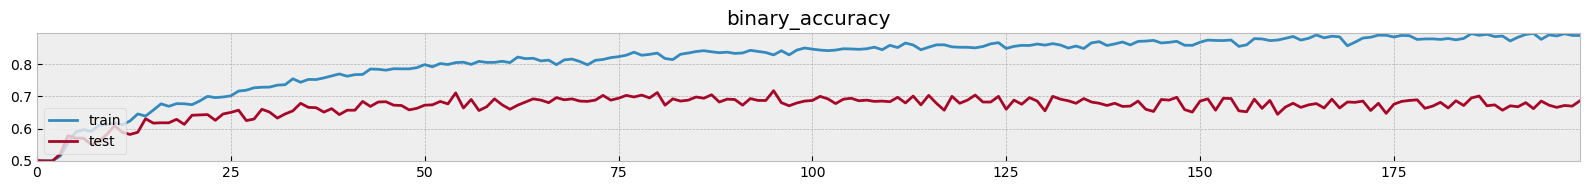

In [261]:
plot_training(history, 'binary_accuracy')

In [262]:
encoder.save('encoder.h5')

# Downstream Task

In [560]:
encoder = load_model('encoderJPY_28_08_s1.3.h5', compile=True)

In [561]:
x_train, x_test, y_train, y_test = load_data(TIMESTEPS)
x_train.shape

Outliers 0.02190467173742223


(5731, 25)

In [562]:
# Compute embeddings for each window
x_train_embeds = encoder.predict(x_train)
x_test_embeds = encoder.predict(x_test)

45/45 [==============================] - 0s 2ms/step


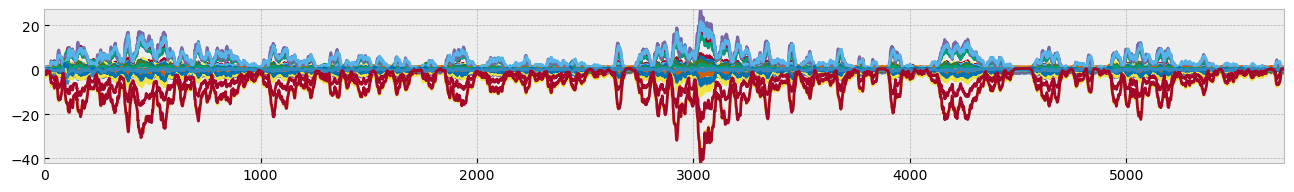

In [563]:
plot(x_train_embeds)

In [564]:
# Normalize each embedding vector to unit norm
x_train_embeds = x_train_embeds / np.linalg.norm(x_train_embeds, axis=1, keepdims=True)
x_test_embeds = x_test_embeds / np.linalg.norm(x_test_embeds, axis=1, keepdims=True)

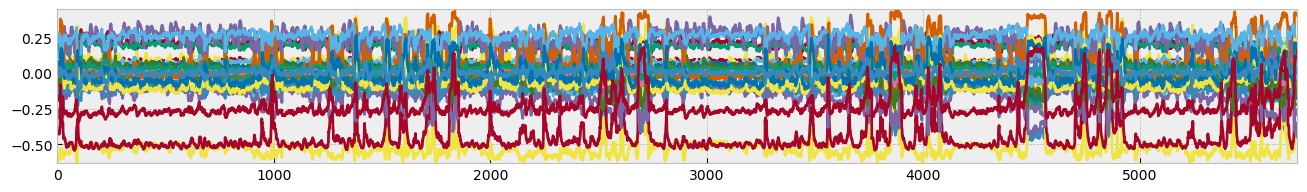

In [565]:
plot(x_train_embeds)

In [566]:
# Linear Regression with CPC embeddings
reg_model = LinearRegression()
reg_model.fit(x_train_embeds, y_train)
eval('CPC-LR', reg_model.predict(x_test_embeds), y_test)
evals

,Persistence,Zero,Mean,LR,LSTM,CPC-LR
RMSE,0.007791,0.005562,0.005567,0.005762,0.005775,0.005490
MAE,0.005549,0.003885,0.003894,0.004053,0.004170,0.003855


In [567]:
train_returns = timeseries[TIMESTEPS-1:][:len(x_train)]
test_returns = timeseries[-len(x_test)-1:-1]

Strategy Sharpe 1.3122592597800111
Benchmark Sharpe 0.5297724608720022


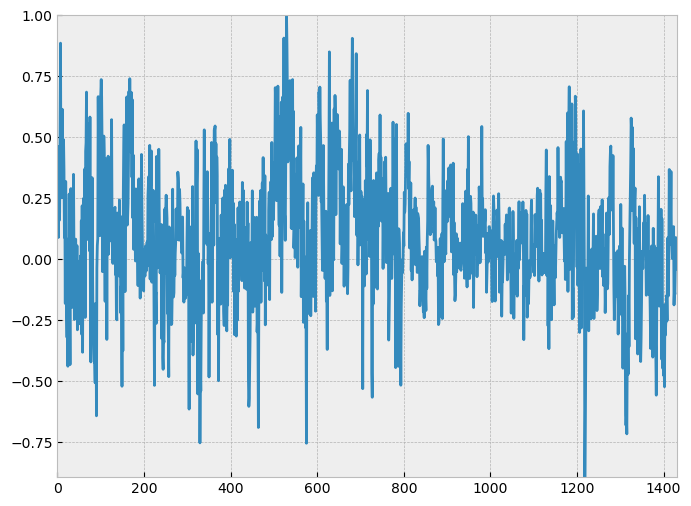

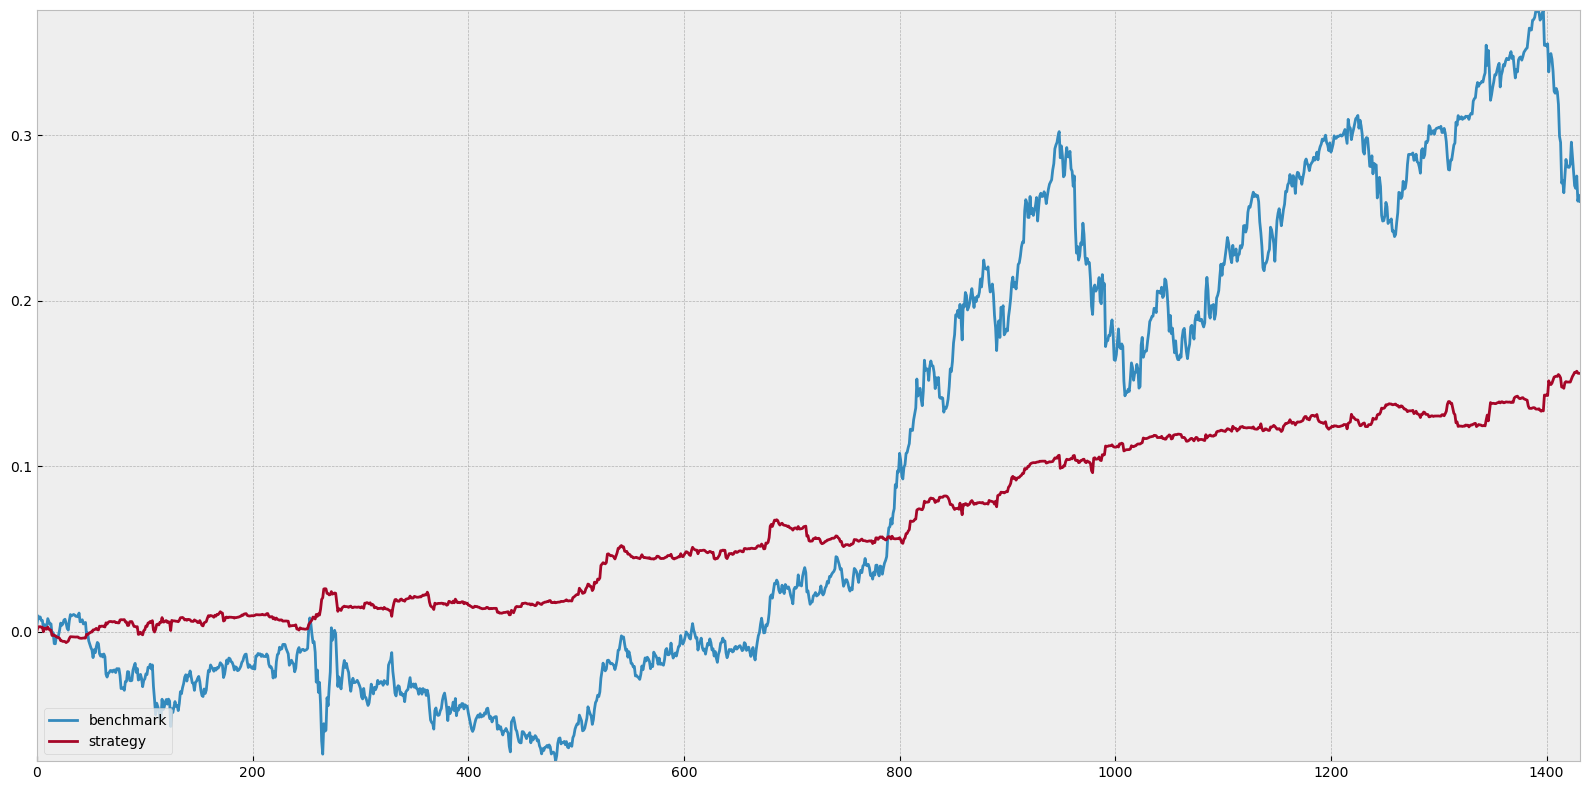

In [656]:
allocations = reg_model.predict(x_test_embeds)
m = 1 / max(allocations)
allocations = (allocations * m)
portfolio_returns = test_returns[1:] * allocations[:-1]

print('Strategy Sharpe', sharpe_ratio(portfolio_returns).numpy())
print('Benchmark Sharpe', sharpe_ratio(test_returns).numpy())

plot(allocations)
plot_timeseries(index=np.arange(len(test_returns)-1), benchmark=np.cumsum(test_returns[1:]), strategy=np.cumsum(portfolio_returns))

In [669]:
timeseries = download('EURGBP=X')['Close']
# Transform to log returns
timeseries = np.log(timeseries).diff().dropna()

def load_data(w=None):
    X = timeseries.values

    # remove outliers
    outliers = np.quantile(np.abs(X), 0.99)
    X = np.clip(X, -outliers, outliers)
    print('Outliers', outliers)

    # scale
    X = X / outliers

    # generate lags
    X = window(X, w).astype(np.float32)
    y = timeseries[w:]
    return split(X, y, 0.2)

x_train, x_test, y_train, y_test = load_data(WINDOWS * TIMESTEPS)

assert(np.isfinite(x_train).all() == True)
assert(np.isfinite(y_train).all() == True)

encoder = load_model('encoderJPY_28_08_s1.3.h5', compile=True)
x_train, x_test, y_train, y_test = load_data(TIMESTEPS)
# Compute embeddings for each window
x_train_embeds = encoder.predict(x_train)
x_test_embeds = encoder.predict(x_test)
# Normalize each embedding vector to unit norm
x_train_embeds = x_train_embeds / np.linalg.norm(x_train_embeds, axis=1, keepdims=True)
x_test_embeds = x_test_embeds / np.linalg.norm(x_test_embeds, axis=1, keepdims=True)
# Linear Regression with CPC embeddings
reg_model = LinearRegression()
reg_model.fit(x_train_embeds, y_train)
eval('CPC-LR', reg_model.predict(x_test_embeds), y_test)

Outliers 0.015853413913359204
Outliers 0.015853413913359204
42/42 [==============================] - 0s 3ms/step


In [670]:
train_returns = timeseries[TIMESTEPS-1:][:len(x_train)]
test_returns = timeseries[-len(x_test)-1:-1]

Strategy Sharpe 0.7405104632599937
Benchmark Sharpe -0.12157404291727746


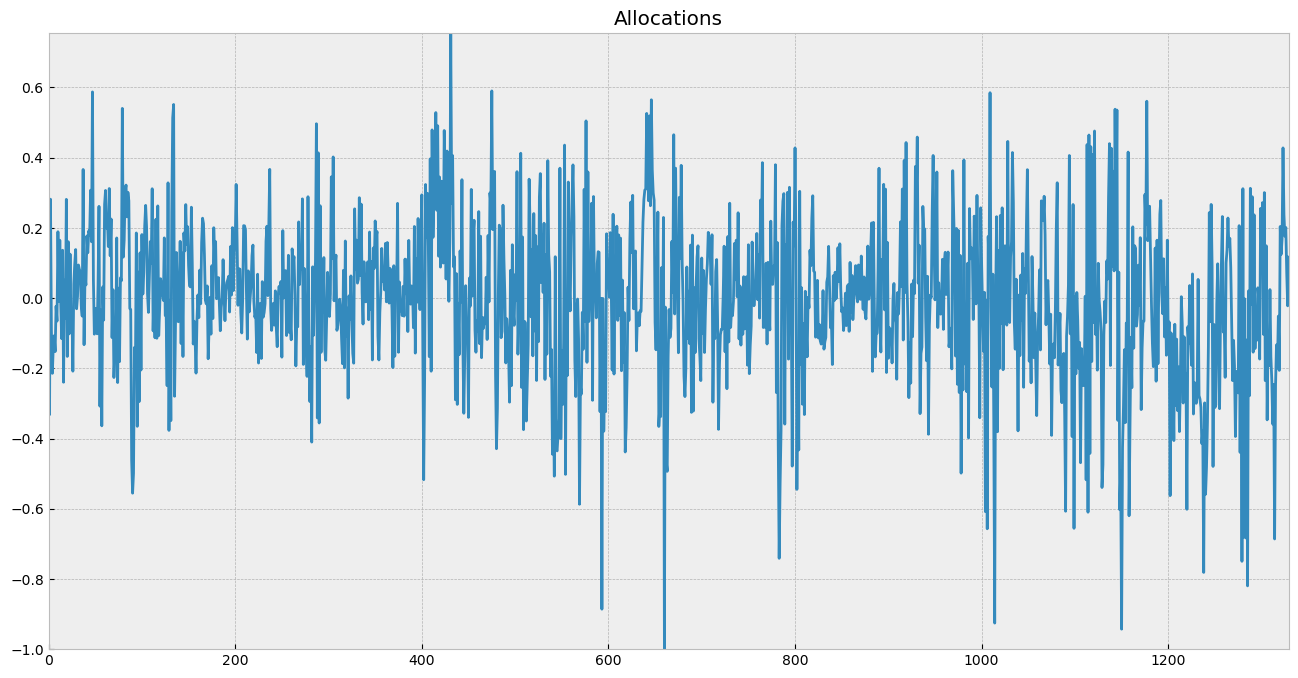

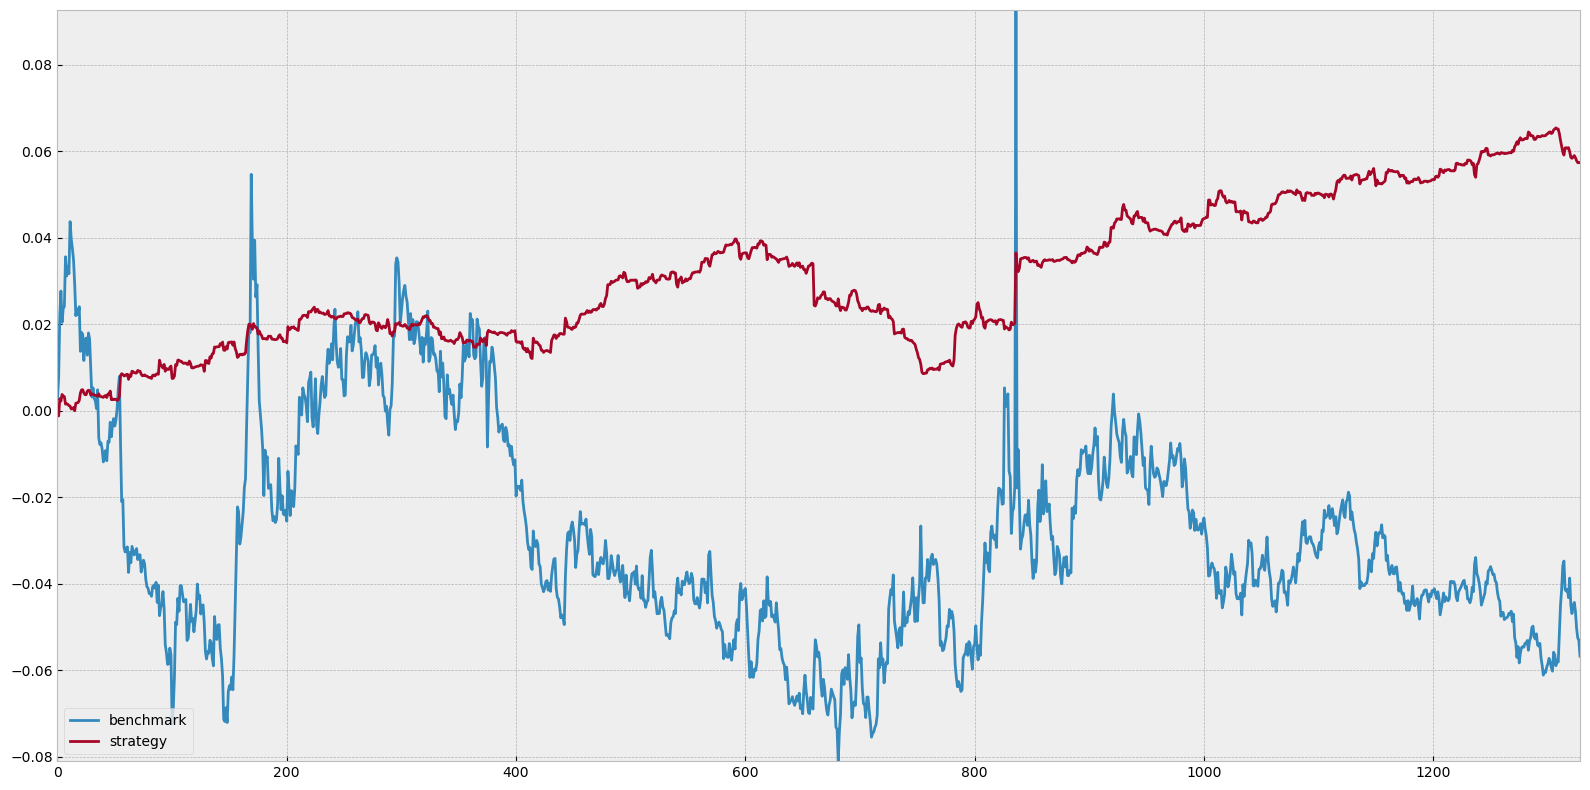

In [671]:
allocations = reg_model.predict(x_test_embeds)
m = 1 / max(abs(allocations))
allocations = (allocations * m)
portfolio_returns = test_returns[1:] * allocations[:-1]

print('Strategy Sharpe', sharpe_ratio(portfolio_returns).numpy())
print('Benchmark Sharpe', sharpe_ratio(test_returns).numpy())

plot(allocations, True)
plot_timeseries(index=np.arange(len(test_returns)-1), benchmark=np.cumsum(test_returns[1:]), strategy=np.cumsum(portfolio_returns))

# IGNORE FROM HERE

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_tsne = tsne.fit_transform(x_train_embeds)

# Apply K-means clustering
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(x_train_embeds)

# Visualize the clusters using the t-SNE embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('Cluster analysis of CPC embeddings')
plt.show()

Model: "model_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_197 (InputLayer)      [(None, 32)]              0         
                                                                 
 dense_167 (Dense)           (None, 64)                2112      
                                                                 
 dropout_71 (Dropout)        (None, 64)                0         
                                                                 
 dense_168 (Dense)           (None, 64)                4160      
                                                                 
 dropout_72 (Dropout)        (None, 64)                0         
                                                                 
 dense_169 (Dense)           (None, 1)                 65        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable 

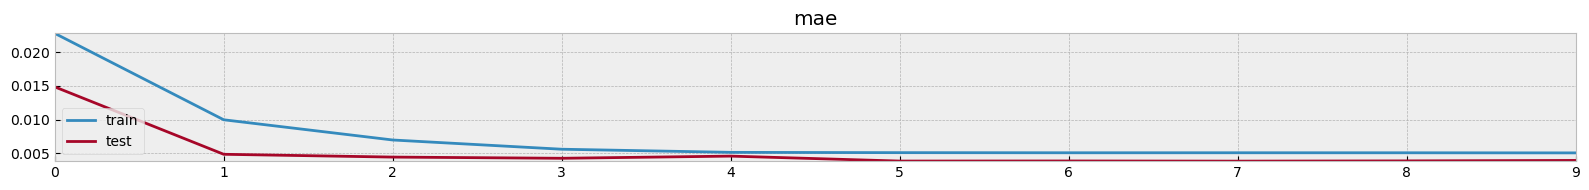

45/45 [==============================] - 0s 4ms/step


In [520]:
def build_dense(input_shape):
    input = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='linear')(x)
    return Model(input, x)

model = build_dense(CODE_SIZE)
model.compile(loss='mse', metrics=['mae'])
model.summary()

history = model.fit(x_train_embeds, y_train, batch_size=25, epochs=10, validation_data=(x_test_embeds, y_test))
plot_training(history, 'mae')

eval('CPC', model.predict(x_test_embeds), y_test)

In [521]:
evals

,Persistence,Zero,Mean,LR,LSTM,CPC-LR,CPC
RMSE,0.007781,0.005560,0.005564,0.005759,0.005620,0.005485,0.005622
MAE,0.005540,0.003879,0.003887,0.004047,0.003889,0.003822,0.003927


# Optimize Sharpe

Model: "model_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_190 (InputLayer)      [(None, 32)]              0         
                                                                 
 dense_154 (Dense)           (None, 1)                 33        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
23/23 [==============================] - 3s 107ms/step - loss: -0.0227 - val_loss: 0.3838
Epoch 2/5
23/23 [==============================] - 1s 30ms/step - loss: -0.0628 - val_loss: 0.3976
Epoch 3/5
23/23 [==============================] - 0s 22ms/step - loss: -0.3285 - val_loss: 0.4071
Epoch 4/5
23/23 [==============================] - 0s 13ms/step - loss: 0.0436 - val_loss: 0.4323
Epoch 5/5
23/23 [==============================] - 0s 18ms/ste

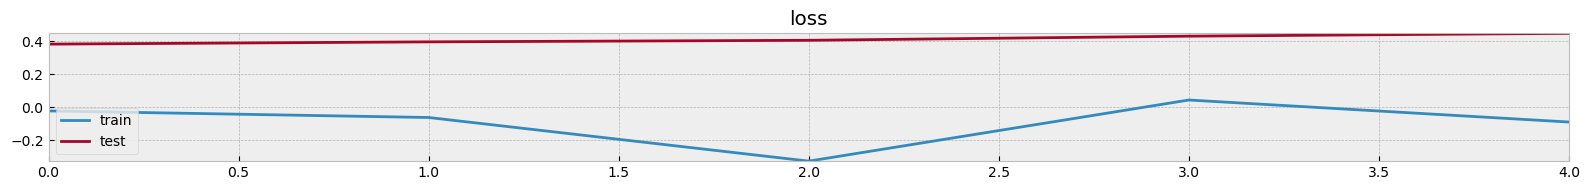

In [502]:
def sharpe_loss(log_returns, allocations):
    portfolio_returns = log_returns[1:, 0] * allocations[:-1, 0]
    # Negative Sharpe ratio (to maximize it)
    return -sharpe_ratio(portfolio_returns)

def build_dense(input_shape):
    input = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='tanh')(input)
    return Model(input, x)

model = build_dense((CODE_SIZE))
model.compile(loss=sharpe_loss, optimizer='adam')
model.summary()

history = model.fit(x_train_embeds, train_returns, batch_size=251, epochs=5, validation_data=(x_test_embeds, test_returns))
plot_training(history, 'loss')


In [503]:
allocations = model.predict(x_test_embeds)[:, 0]
portfolio_returns = test_returns[1:] * allocations[:-1]

print('Strategy Sharpe', sharpe_ratio(portfolio_returns).numpy())
print('Benchmark Sharpe', sharpe_ratio(test_returns).numpy())

45/45 [==============================] - 0s 3ms/step
Strategy Sharpe -0.4953967959944195
Benchmark Sharpe 0.5261902568951536


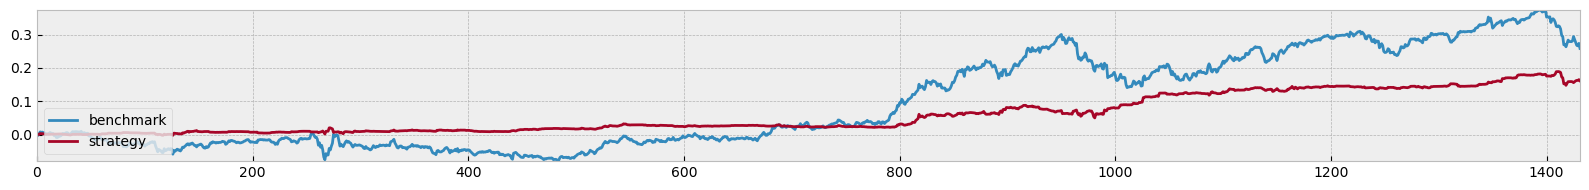

In [540]:
plot_timeseries(index=np.arange(len(test_returns)-1), benchmark=np.cumsum(test_returns[1:]), strategy=np.cumsum(portfolio_returns))

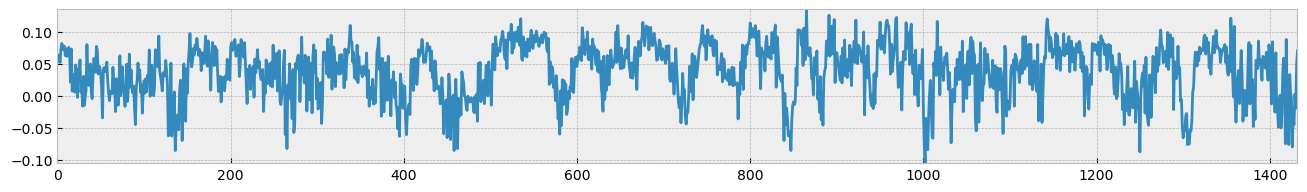

In [354]:
plot(allocations)